## Basket call options
$$
h(\vec{x}) = \max\{\vec{w}^T\cdot \vec{x} - \kappa, 0\}
$$
where $\vec{w}$ is a set of weights for the different stocks
This can be rephrased as
$$
payoff = \max(\sum_i w_ix_i - \kappa, 0)
$$
where the weights are fixed, but each $x_i$ follows its own distribution

# Distribution
We assume a log-normal distribution of the prices

In [1]:
import numpy as np
from qiskit_finance.circuit.library import LogNormalDistribution
# number of qubits per dimension to represent the uncertainty
num_uncertainty_qubits = 3

# parameters for considered random distribution
S = 2.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.04  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)
print(mu)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# map to higher dimensional distribution
# for simplicity assuming dimensions are independent and identically distributed)
dimension = 2
num_qubits = [num_uncertainty_qubits] * dimension
low = low * np.ones(dimension)
high = high * np.ones(dimension)
mu = mu * np.ones(dimension)
cov = sigma**2 * np.eye(dimension) # covariance matrix

# construct circuit
u = LogNormalDistribution(num_qubits=num_qubits, mu=mu, sigma=cov, bounds=list(zip(low, high)))
# u = NormalDistribution(num_qubits=num_qubits, mu=mu, sigma=cov, bounds=list(zip(low, high)))

0.6887636189161097


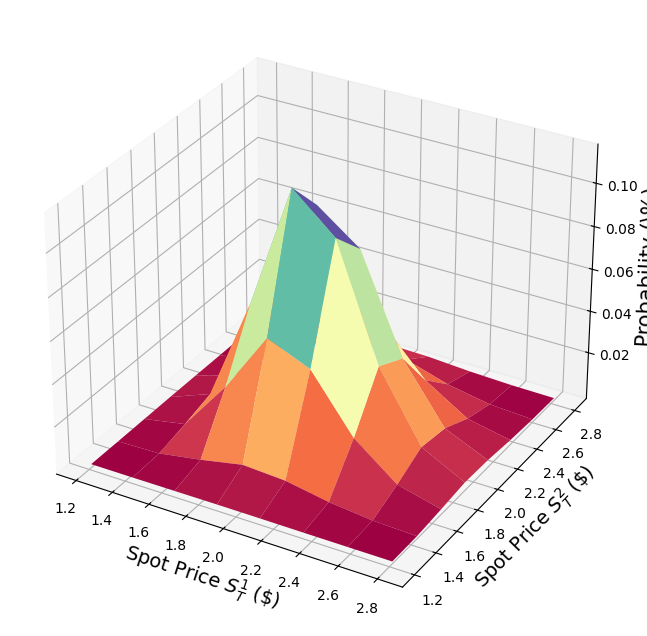

In [2]:
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

# plot PDF of uncertainty model
x = [v[0] for v in u.values]
y = [v[1] for v in u.values]
z = u.probabilities
# z = map(float, z)
# z = list(map(float, z))
resolution = np.array([2**n for n in num_qubits]) * 1j
grid_x, grid_y = np.mgrid[min(x) : max(x) : resolution[0], min(y) : max(y) : resolution[1]]
grid_z = griddata((x, y), z, (grid_x, grid_y))
plt.figure(figsize=(10, 8))
ax = plt.axes(projection="3d")
ax.plot_surface(grid_x, grid_y, grid_z, cmap=plt.cm.Spectral)
ax.set_xlabel("Spot Price $S_T^1$ (\$)", size=14)
ax.set_ylabel("Spot Price $S_T^2$ (\$)", size=14)
ax.set_zlabel("Probability (\%)", size=15)
plt.show()



# load payoff functions
Since the weighted sum operator (in its current implementation) can only sum up integers, we need to map from the original ranges to the representable range to estimate the result, and reverse this mapping before interpreting the result. 

In [3]:
from qiskit.circuit.library import WeightedAdder, LinearAmplitudeFunction

# determine number of qubits required to represent total loss
weights = []
for n in num_qubits:
    for i in range(n):
        weights += [2**i]
# we can see that weights is according to the binary representation of the number
print(weights)

##################
# key question
# the current weights are the same for both dimensions
# how do we make them different?
#################
# s_1 + s_2
# 0.3 s_1 + 0.7 s_2 


[1, 2, 4, 1, 2, 4]


In [18]:
# create aggregation circuit
agg = WeightedAdder(sum(num_qubits), weights) # integer weights only
n_s = agg.num_sum_qubits
n_aux = agg.num_qubits - n_s - agg.num_state_qubits  # number of additional qubits
agg.draw()

┌───────────────┐
state_0: ┤0              ├
         │               │
state_1: ┤1              ├
         │               │
state_2: ┤2              ├
         │               │
state_3: ┤3              ├
         │               │
state_4: ┤4              ├
         │               │
state_5: ┤5              ├
         │               │
  sum_0: ┤6              ├
         │   circuit-649 │
  sum_1: ┤7              ├
         │               │
  sum_2: ┤8              ├
         │               │
  sum_3: ┤9              ├
         │               │
carry_0: ┤10             ├
         │               │
carry_1: ┤11             ├
         │               │
carry_2: ┤12             ├
         │               │
control: ┤13             ├
         └───────────────┘

In [32]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer

circ = QuantumCircuit(agg.num_qubits, 4)
# first_number qubit 0 to 2
circ.x([0])

#second number qubit 3 to 5
circ.x([3])

circ.append(agg.to_instruction(), range(agg.num_qubits))
circ.measure(range(6,10), range(4))

In [33]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
job = execute(circ, Aer.get_backend('qasm_simulator'), shots=1000)
counts = job.result().get_counts()
print(counts)

{'0010': 1000}


In [5]:
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price = 3.5

# map strike price from [low, high] to {0, ..., 2^n-1}
max_value = 2**n_s - 1
low_ = low[0]
high_ = high[0]
mapped_strike_price = (
    (strike_price - dimension * low_) / (high_ - low_) * (2**num_uncertainty_qubits - 1)
)
print(mapped_strike_price)
# set the approximation scaling for the payoff function
c_approx = 0.25

# setup piecewise linear objective fcuntion
breakpoints = [0, mapped_strike_price]
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = 2 * (2**num_uncertainty_qubits - 1) - mapped_strike_price
basket_objective = LinearAmplitudeFunction(
    n_s,
    slopes,
    offsets,
    domain=(0, max_value),
    image=(f_min, f_max),
    rescaling_factor=c_approx,
    breakpoints=breakpoints,
)



4.739865245237558


In [12]:
from qiskit import QuantumRegister, AncillaRegister, QuantumCircuit
# define overall multivariate problem
qr_state = QuantumRegister(u.num_qubits, "state")  # to load the probability distribution
qr_obj = QuantumRegister(1, "obj")  # to encode the function values
ar_sum = AncillaRegister(n_s, "sum")  # number of qubits used to encode the sum
ar = AncillaRegister(max(n_aux, basket_objective.num_ancillas), "work")  # additional qubits

objective_index = u.num_qubits

basket_option = QuantumCircuit(qr_state, qr_obj, ar_sum, ar)
basket_option.append(u, qr_state)
basket_option.append(agg, qr_state[:] + ar_sum[:] + ar[:n_aux])
basket_option.append(basket_objective, ar_sum[:] + qr_obj[:] + ar[: basket_objective.num_ancillas])

print(basket_option.draw())
print("objective qubit index", objective_index)



         ┌───────┐┌─────────┐      
state_0: ┤0      ├┤0        ├──────
         │       ││         │      
state_1: ┤1      ├┤1        ├──────
         │       ││         │      
state_2: ┤2      ├┤2        ├──────
         │  P(X) ││         │      
state_3: ┤3      ├┤3        ├──────
         │       ││         │      
state_4: ┤4      ├┤4        ├──────
         │       ││         │      
state_5: ┤5      ├┤5        ├──────
         └───────┘│         │┌────┐
    obj: ─────────┤         ├┤4   ├
                  │         ││    │
  sum_0: ─────────┤6  adder ├┤0   ├
                  │         ││    │
  sum_1: ─────────┤7        ├┤1   ├
                  │         ││    │
  sum_2: ─────────┤8        ├┤2   ├
                  │         ││    │
  sum_3: ─────────┤9        ├┤3 F ├
                  │         ││    │
 work_0: ─────────┤10       ├┤5   ├
                  │         ││    │
 work_1: ─────────┤11       ├┤6   ├
                  │         ││    │
 work_2: ─────────┤12       

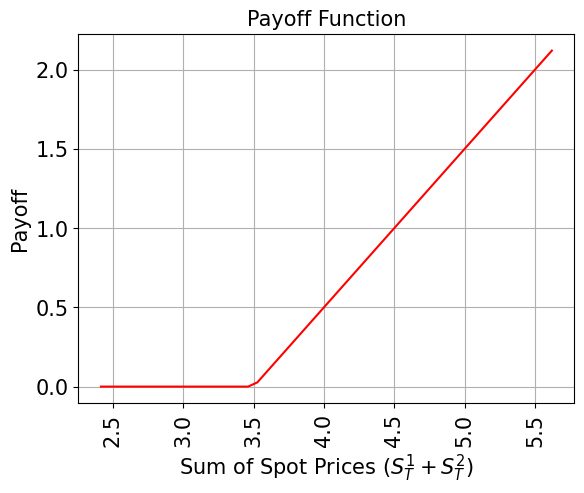

In [13]:
# plot exact payoff function (evaluated on the grid of the uncertainty model)
x = np.linspace(sum(low), sum(high))
y = np.maximum(0, x - strike_price)
plt.plot(x, y, "r-")
plt.grid()
plt.title("Payoff Function", size=15)
plt.xlabel("Sum of Spot Prices ($S_T^1 + S_T^2)$", size=15)
plt.ylabel("Payoff", size=15)
plt.xticks(size=15, rotation=90)
plt.yticks(size=15)
plt.show()



In [19]:
# evaluate exact expected value
sum_values = np.sum(u.values, axis=1)
exact_value = np.dot(
    u.probabilities[sum_values >= strike_price],
    sum_values[sum_values >= strike_price] - strike_price,
)
print("exact expected value:\t%.4f" % exact_value)

exact expected value:	0.5252


In [20]:
from qiskit_aer.primitives import Sampler
basket_option_measure = basket_option.measure_all(inplace=False)
sampler = Sampler()
job = sampler.run(basket_option_measure)

In [21]:
# set target precision and confidence level
from qiskit.utils import QuantumInstance
from qiskit_aer import AerSimulator
from ModifiedIQAE.algorithms.amplitude_estimators.mod_iae import ModifiedIterativeAmplitudeEstimation
from qiskit_algorithms import EstimationProblem

epsilon = 0.01
alpha = 0.05

problem = EstimationProblem(
    state_preparation=basket_option,
    objective_qubits=[objective_index],
    post_processing=basket_objective.post_processing,
)
# construct amplitude estimation

qi = QuantumInstance(backend=AerSimulator(), shots=200)
ae = ModifiedIterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, quantum_instance=qi)
result = ae.estimate(problem, shots=200)



/var/folders/1b/41tf8c954h79vyg2kpcm8cqc0000gn/T/ipykernel_20986/2758317772.py:17: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  qi = QuantumInstance(backend=AerSimulator(), shots=200)


In [22]:
conf_int = (
    np.array(result.confidence_interval_processed)
    / (2**num_uncertainty_qubits - 1)
    * (high_ - low_)
)
print("Exact value:        \t%.4f" % exact_value)
print(
    "Estimated value:    \t%.4f"
    % (result.estimation_processed / (2**num_uncertainty_qubits - 1) * (high_ - low_))
)
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))



Exact value:        	0.5252
Estimated value:    	0.5393
Confidence interval:	[0.5091, 0.5696]
